In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import dump

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer, precision_score
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split

In [18]:
df = pd.read_csv('TechStockDataForModelPreppedNoOutliers.csv')


train, test = train_test_split(df, test_size=0.1, random_state=42)

X_train, y_train = train.drop(['Target', 'SP_change'], axis=1), train['Target']
X_test, y_test = test.drop(['Target', 'SP_change'], axis=1), test['Target']


In [19]:
df.head()

,HighCloseVolAvg_1,HighCloseVolAvg_10,HighCloseVolAvg_20,RSI,RSI_3_day_avg,RSI_10_day_avg,MACD,MACDHist,SP_change,Target
0,0.010693,0.018017,0.025879,51.144248,50.798745,45.626276,-2.243074,0.184151,0.023666,Yes
1,0.012521,0.015817,0.026274,53.432165,52.309578,46.428708,-1.884980,0.433796,0.008462,No
2,0.007963,0.014928,0.024169,54.732901,53.103105,47.573935,-1.509083,0.647755,-0.002483,No
3,0.020793,0.013226,0.021916,49.056194,52.407087,48.540104,-1.477920,0.543134,0.030791,Yes
4,0.001288,0.013255,0.020848,53.817714,52.535603,49.484500,-1.177072,0.675186,0.004034,No


In [20]:
df.shape

(36599, 10)

In [59]:
### Helper functions

def model_fit_and_scores(grid, X, y):
    """
    Fit a model to X and y using a gridsearchCV with param grid.
    Return the model, model's best params, 5 best scores.
    """
    grid.fit(X,y)
    best_params = grid.best_params_
    best_scores = np.sort(grid.cv_results_['mean_test_score'])[::-1][:5]

    return grid, best_params, best_scores


def model_evaluation(model, X_test, y_test):
    """
    Evaluate a model by getting predictions, probabilities,
    print confusion matrix and classification report, then bar plot the results.
    """
    preds = model.predict(X_test)
    
    plot_confusion_matrix(model, X_test, y_test)
        
    print(classification_report(y_test, preds))


def compare_prediction(model, X_test, y_test, test):
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1]
    
    data = np.column_stack((test['SP_change'], y_test, preds, probs))

    test_preds_df = pd.DataFrame(data=data, columns=['SP_change', 'Target', 'Predicted', 'Probability'])
    
    prob_thresh = np.linspace(0.4, 0.8, 25)
    
    sp_changes = df['SP_change'].iloc[y_test.index]

    data = []
    for prob in prob_thresh:
        ser = test_preds_df[test_preds_df['Probability']>=prob]['SP_change']
        
        avg = ser.mean()
        count = ser.shape[0]
        
        data.append([avg, count])
        
    prob_sp_df = pd.DataFrame(data=data, index=prob_thresh, columns=['SP_increase', 'Count'])
    
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8, 15))
    
    sns.barplot(data=test_preds_df, x='Predicted', y='SP_change', ax=ax[1])
    
    ax[0].plot(prob_sp_df.index, prob_sp_df['SP_increase'])
    
    print(prob_sp_df)

In [41]:
preprocessing = ColumnTransformer([
    ('scaler', StandardScaler(), X_train.select_dtypes(include='number').columns),
])

custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label='Yes')


log_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('log', LogisticRegression(max_iter=10000)),
])

log_param_grid = {'log__penalty': ['l2'],
                  'log__C': [0.005, 0.1, 0.5],
                  'log__solver': ['lbfgs']
                 }

custom_scorer = make_scorer(precision_score, 
                            greater_is_better=True, 
                            pos_label='Yes')

log_grid = GridSearchCV(estimator=log_pipeline, 
                        param_grid=log_param_grid, 
                        cv=5, 
                        scoring=custom_scorer, 
                        verbose=2)

In [23]:
log_model, log_params, log_best_scores = model_fit_and_scores(log_grid, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END ...log__C=0.005, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END .....log__C=0.1, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END .....log__C=0.1, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END .....log__C=0.1, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END .....log__C=0.1, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END .....log__C=0.1, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END .....log__C=0.5, log__penalty=l2, log__solver=lbfgs; total time=   0.0s
[CV] END .....log__C=0.5, log__penalty=l2, log__s

In [24]:
log_params

{'log__C': 0.005, 'log__penalty': 'l2', 'log__solver': 'lbfgs'}

In [25]:
log_best_scores

array([0.55096356, 0.55076752, 0.55036239])

In [26]:
preprocessing_poly = ColumnTransformer([
    ('poly', PolynomialFeatures(degree=2), X_train.select_dtypes(include='number').columns),
    ('scaler', StandardScaler(), X_train.select_dtypes(include='number').columns),
])

custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label='Yes')


log_pipeline_poly = Pipeline([
    ('preprocessing_poly', preprocessing_poly),
    ('log_poly', LogisticRegression(max_iter=10000)),
])

log_param_grid_poly = {'log_poly__penalty': ['l2'],
                  'log_poly__C': [0.005, 0.1, 0.5],
                  'log_poly__solver': ['lbfgs']
                 }

custom_scorer = make_scorer(precision_score, 
                            greater_is_better=True, 
                            pos_label='Yes')

log_grid_poly = GridSearchCV(estimator=log_pipeline_poly, 
                        param_grid=log_param_grid_poly, 
                        cv=5, 
                        scoring=custom_scorer, 
                        verbose=2)

In [27]:
log_model_poly, log_params_poly, log_best_scores_poly = model_fit_and_scores(log_grid_poly, X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END log_poly__C=0.005, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   2.1s
[CV] END log_poly__C=0.005, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   1.6s
[CV] END log_poly__C=0.005, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   2.1s
[CV] END log_poly__C=0.005, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   1.1s
[CV] END log_poly__C=0.005, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   1.3s
[CV] END log_poly__C=0.1, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   1.6s
[CV] END log_poly__C=0.1, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   1.7s
[CV] END log_poly__C=0.1, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   1.5s
[CV] END log_poly__C=0.1, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   1.8s
[CV] END log_poly__C=0.1, log_poly__penalty=l2, log_poly__solver=lbfgs; total time=   1.6s
[CV] END log_poly__C

In [28]:
log_params_poly

{'log_poly__C': 0.1, 'log_poly__penalty': 'l2', 'log_poly__solver': 'lbfgs'}

In [29]:
log_best_scores_poly

array([0.55368912, 0.55320811, 0.55288345])

          SP_increase  Count
0.400000     0.030233  24310
0.416667     0.031196  21791
0.433333     0.032209  19198
0.450000     0.032971  16810
0.466667     0.033908  14579
0.483333     0.034651  12442
0.500000     0.035392  10468
0.516667     0.036084   8697
0.533333     0.036744   7057
0.550000     0.037547   5548
0.566667     0.038423   4324
0.583333     0.037932   3253
0.600000     0.039155   2297
0.616667     0.040660   1541
0.633333     0.042831    891
0.650000     0.040709    504
0.666667     0.040252    234
0.683333     0.041180    103
0.700000     0.042597     36
0.716667     0.046993     12
0.733333     0.081266      3
0.750000     0.090385      2
0.766667          NaN      0
0.783333          NaN      0
0.800000          NaN      0


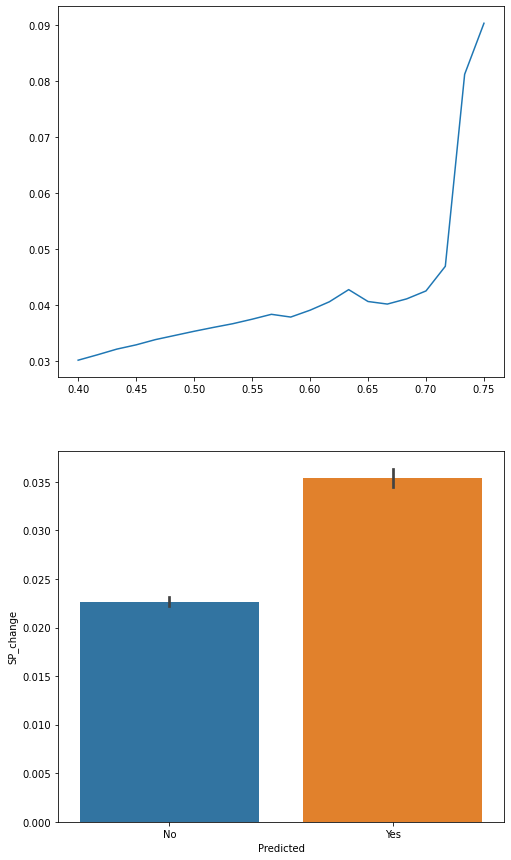

In [62]:
compare_prediction(log_model, X_train, y_train, train)

              precision    recall  f1-score   support

          No       0.58      0.74      0.65     17724
         Yes       0.55      0.38      0.45     15215

    accuracy                           0.57     32939
   macro avg       0.57      0.56      0.55     32939
weighted avg       0.57      0.57      0.56     32939



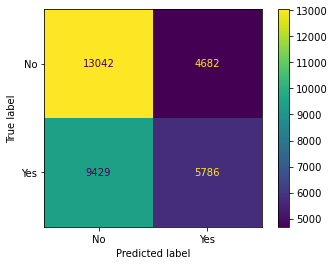

In [63]:
model_evaluation(log_model, X_train, y_train)

          SP_increase  Count
0.400000     0.030256  23959
0.416667     0.031281  21694
0.433333     0.032246  19375
0.450000     0.033190  17098
0.466667     0.033961  14846
0.483333     0.034610  12791
0.500000     0.035560  10807
0.516667     0.036384   9030
0.533333     0.037531   7344
0.550000     0.038667   5859
0.566667     0.039413   4526
0.583333     0.040113   3423
0.600000     0.039843   2431
0.616667     0.041898   1622
0.633333     0.044467   1006
0.650000     0.046103    586
0.666667     0.045819    325
0.683333     0.040470    170
0.700000     0.041459     81
0.716667     0.055054     46
0.733333     0.078959     27
0.750000     0.084724     16
0.766667     0.073990     12
0.783333     0.098291      8
0.800000     0.166889      5


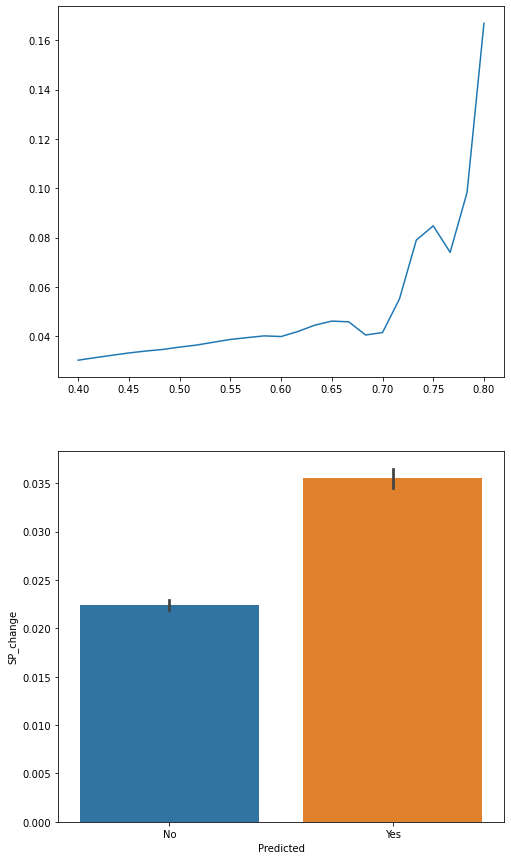

In [64]:
compare_prediction(log_model_poly, X_train, y_train, train)

              precision    recall  f1-score   support

          No       0.58      0.73      0.65     17724
         Yes       0.56      0.39      0.46     15215

    accuracy                           0.57     32939
   macro avg       0.57      0.56      0.55     32939
weighted avg       0.57      0.57      0.56     32939



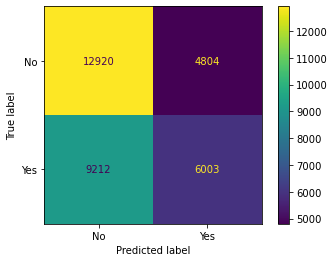

In [65]:
model_evaluation(log_model_poly, X_train, y_train)

### Evaluate on Test Set

          SP_increase  Count
0.400000     0.031490   2710
0.416667     0.032448   2415
0.433333     0.033698   2097
0.450000     0.035110   1827
0.466667     0.036155   1559
0.483333     0.036630   1313
0.500000     0.037302   1112
0.516667     0.037716    933
0.533333     0.037044    743
0.550000     0.037013    602
0.566667     0.036598    460
0.583333     0.037017    347
0.600000     0.036838    246
0.616667     0.038657    160
0.633333     0.044680    100
0.650000     0.055569     52
0.666667     0.049309     21
0.683333     0.027585      9
0.700000     0.016985      3
0.716667          NaN      0
0.733333          NaN      0
0.750000          NaN      0
0.766667          NaN      0
0.783333          NaN      0
0.800000          NaN      0


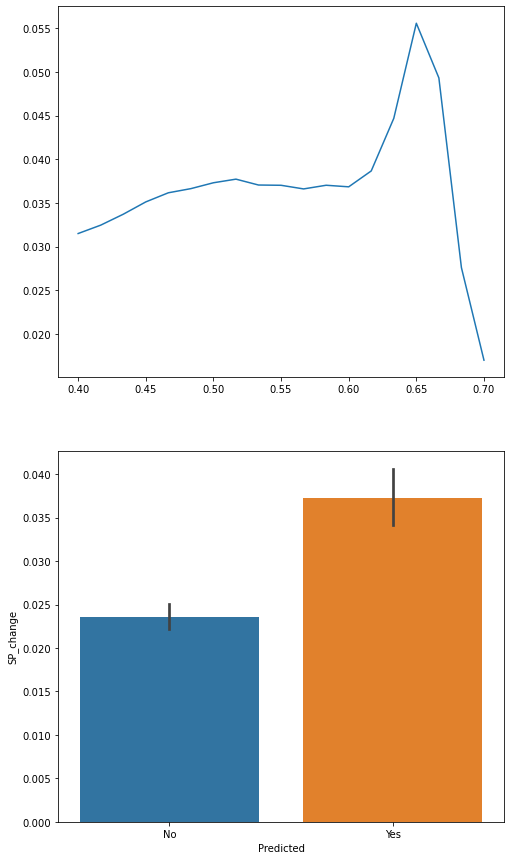

In [94]:
compare_prediction(log_model, X_test, y_test, test)

          SP_increase  Count
0.400000     0.031476   2681
0.416667     0.032618   2404
0.433333     0.033772   2125
0.450000     0.035407   1853
0.466667     0.036106   1600
0.483333     0.036355   1371
0.500000     0.037671   1162
0.516667     0.038132    963
0.533333     0.038505    772
0.550000     0.039107    629
0.566667     0.037393    494
0.583333     0.035436    387
0.600000     0.037643    266
0.616667     0.039910    178
0.633333     0.048991    112
0.650000     0.052200     73
0.666667     0.045553     39
0.683333     0.042223     20
0.700000     0.022069      9
0.716667     0.009652      4
0.733333     0.014421      3
0.750000          NaN      0
0.766667          NaN      0
0.783333          NaN      0
0.800000          NaN      0


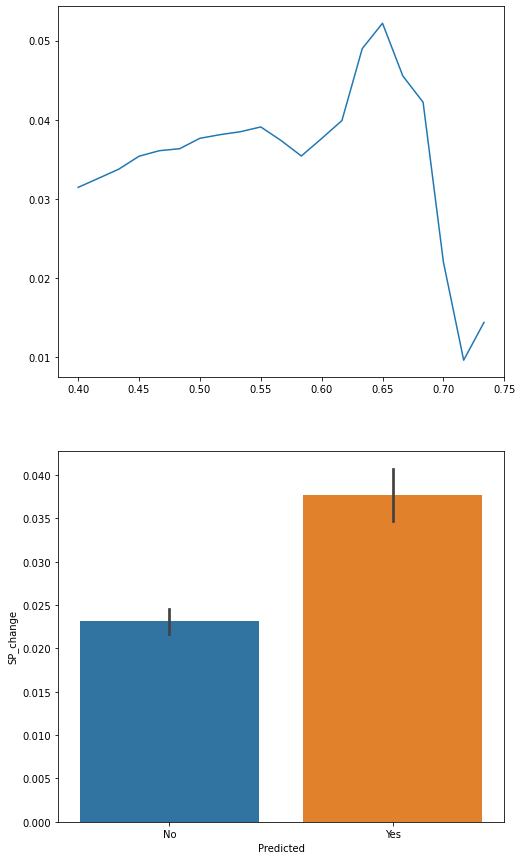

In [95]:
compare_prediction(log_model_poly, X_test, y_test, test)

              precision    recall  f1-score   support

          No       0.58      0.76      0.66      1956
         Yes       0.57      0.37      0.45      1704

    accuracy                           0.58      3660
   macro avg       0.58      0.57      0.56      3660
weighted avg       0.58      0.58      0.56      3660



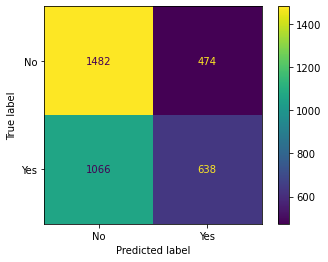

In [97]:
model_evaluation(log_model, X_test, y_test)

              precision    recall  f1-score   support

          No       0.59      0.75      0.66      1956
         Yes       0.58      0.39      0.47      1704

    accuracy                           0.58      3660
   macro avg       0.58      0.57      0.56      3660
weighted avg       0.58      0.58      0.57      3660



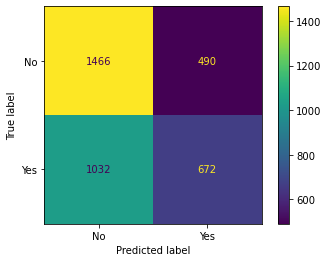

In [98]:
model_evaluation(log_model_poly, X_test, y_test)

As we can see, both models perform very closely on the test set compared to each other and also perform similary to the training set evaluation indicating that it is not overfit. Since it is far less computation, I will use the model without polynomial features.

In [100]:
preprocessing_final = ColumnTransformer([
    ('scaler', StandardScaler(), X.select_dtypes(include='number').columns),
])

custom_scorer = make_scorer(precision_score, greater_is_better=True, pos_label='Yes')


log_pipeline_final = Pipeline([
    ('preprocessing_final', preprocessing_final),
    ('log_final', LogisticRegression(max_iter=10000)),
])

log_param_grid_final = {'log_final__penalty': ['l2'],
                  'log_final__C': [0.005],
                  'log_final__solver': ['lbfgs']
                 }

custom_scorer = make_scorer(precision_score, 
                            greater_is_better=True, 
                            pos_label='Yes')

log_grid_final = GridSearchCV(estimator=log_pipeline_final, 
                        param_grid=log_param_grid_final, 
                        cv=5, 
                        scoring=custom_scorer, 
                        verbose=2)

In [106]:
X = df.drop(['SP_change', 'Target'], axis=1)
y = df['Target']

In [107]:
log_grid_final.fit(X, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END log_final__C=0.005, log_final__penalty=l2, log_final__solver=lbfgs; total time=   0.0s
[CV] END log_final__C=0.005, log_final__penalty=l2, log_final__solver=lbfgs; total time=   0.0s
[CV] END log_final__C=0.005, log_final__penalty=l2, log_final__solver=lbfgs; total time=   0.0s
[CV] END log_final__C=0.005, log_final__penalty=l2, log_final__solver=lbfgs; total time=   0.0s
[CV] END log_final__C=0.005, log_final__penalty=l2, log_final__solver=lbfgs; total time=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing_final',
                                        ColumnTransformer(transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         Index(['HighCloseVolAvg_1', 'HighCloseVolAvg_10', 'HighCloseVolAvg_20', 'RSI',
       'RSI_3_day_avg', 'RSI_10_day_avg', 'MACD', 'MACDHist'],
      dtype='object'))])),
                                       ('log_final',
                                        LogisticRegression(max_iter=10000))]),
             param_grid={'log_final__C': [0.005], 'log_final__penalty': ['l2'],
                         'log_final__solver': ['lbfgs']},
             scoring=make_scorer(precision_score, pos_label=Yes), verbose=2)

              precision    recall  f1-score   support

          No       0.58      0.74      0.65     19680
         Yes       0.55      0.38      0.45     16919

    accuracy                           0.57     36599
   macro avg       0.57      0.56      0.55     36599
weighted avg       0.57      0.57      0.56     36599



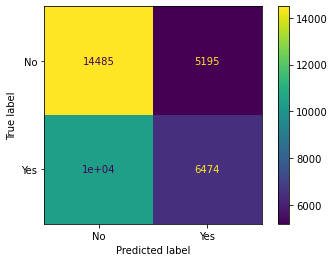

In [108]:
model_evaluation(log_grid_final, X, y)

          SP_increase  Count
0.400000     0.030320  27000
0.416667     0.031287  24242
0.433333     0.032309  21363
0.450000     0.033152  18697
0.466667     0.034105  16209
0.483333     0.034891  13878
0.500000     0.035590  11669
0.516667     0.036420   9744
0.533333     0.036801   7912
0.550000     0.037587   6294
0.566667     0.038004   4891
0.583333     0.037845   3683
0.600000     0.038753   2640
0.616667     0.040295   1778
0.633333     0.042789   1067
0.650000     0.043629    594
0.666667     0.041377    288
0.683333     0.040825    129
0.700000     0.040352     43
0.716667     0.035110     17
0.733333     0.047157      6
0.750000     0.090385      2
0.766667          NaN      0
0.783333          NaN      0
0.800000          NaN      0


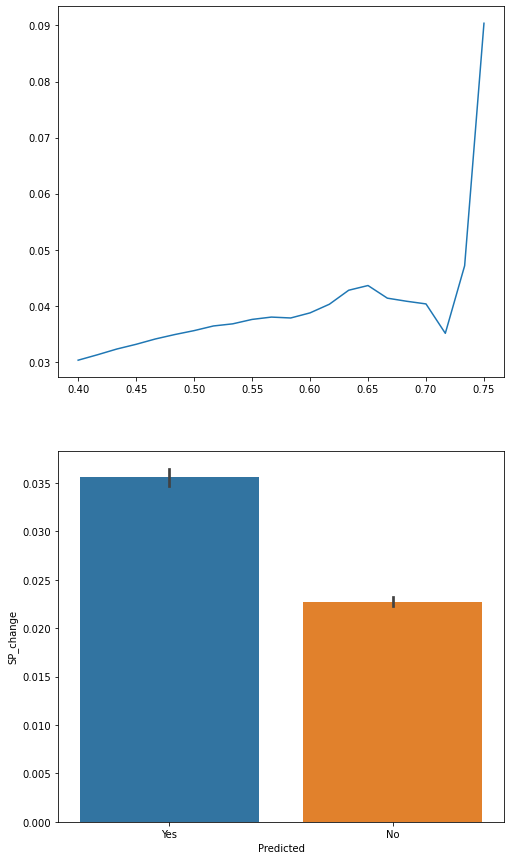

In [109]:
compare_prediction(log_grid_final, X, y, df)

### Future Comments

I think it would be interesting to use keras to see if a neural network could perform better, but I am happy with the results as of now.